In [170]:
%matplotlib inline 
import numpy as np                       
from matplotlib import pyplot as plt
import imageio
import os

## Задача Сода

Бесконечная труба заполнена воздухом ($\gamma = 1.4$), в точке $x = 0$ разделена перегородкой. При $t = 0$ слева от перегородки $(\rho, u, p)^T = (1, 0, 1)$, справа - $(\rho, u, p)^T = (0.125, 0, 0.1)$, где $\rho$ - плотность газа, $u$ - его скорость, $p$ - давление. Найти решение в момент времени $t\approx 0.504$. Считать воздух идеальным газом.

Рассмотрим движение газа, в которой отсутсвуют силы вязкости. Пусть $ \bm{x} = \left (x_1, x_2, x_3 \right)$ – декартова система координат, $\bm{u}(\bm{x}, t) = \left (u_1, u_2, u_3 \right)$ – вектор скорости движения жидкости, $\rho({\bm{x}, t})$ – её плотность, $p({\bm{x}, t})$ – давление, $e({\bm{x}, t})$ – внутренняя энергия, отнесенная к единице массы. Вместо примитивных переменных $(\rho, u, p)^T$ введём консервативные:
$$
\bm{s} = \begin{pmatrix} \rho \\ \rho u \\ \rho(e + u^2/2) \end{pmatrix},
$$ 
тогда 
$$
\bm{f}(\bm{s}) = \begin{pmatrix} \rho u \\ \rho u^2 + p \\ u (\rho e + \rho \frac{u^2}{2}+ p) \end{pmatrix} = \begin{pmatrix} s_2 \\ \frac{s_2^2}{s_1} + p \\ \frac{s_2 (s_3 + p)}{s_1} \end{pmatrix}.
$$
Отсюда, уравнения гидродинамики в одномерном случае примут вид
$$
\frac{\partial{\bm{s}}}{\partial{t}} + \frac{\partial{\bm{f}(\bm{s})}}{\partial{x}} = \bm{0}.
$$

Мы будем рассматривать движение идеального газа с уравнением состояния
$$
e = \frac{p}{\rho (\gamma - 1)}. 
$$

### Схема Лакса-Вендроффа для решения задачи Сода

Предположим, что решение в момент времени $t$ известно, тогда решение в момент времени $t+\tau$ получим с помощью разложения в ряд Тейлора:
$$
\bm{S}(x,t+\tau) = \bm{S}(x,t) + \tau \frac{\partial{\bm{S}}}{\partial{t}} + \frac{1}{2} \tau^2 \frac{\partial^2{\bm{S}}}{\partial{t^2}} + \dots
$$
Заменим производные по $t$ на производные по $x$:
$$
\frac{\partial{\bm{S}}}{\partial{t}} = -\bm{A} \frac{\partial{\bm{S}}}{\partial{x}}, \quad \frac{\partial^2{\bm{S}}}{\partial^2{t}} = - \frac{\partial}{{\partial{t}}} \bm{A} \frac{\partial{\bm{S}}}{\partial{x}} = - \bm{A} \frac{\partial}{{\partial{x}}} \frac{\partial{\bm{S}}}{\partial{t}} = \bm{A}^2 \frac{\partial^2{\bm{S}}}{\partial^2{x}}.
$$
Приходим к схеме Лакса-Вендроффа:
$$
\bm{s}_n^{k+1} = \bm{s}_n^{k} - \frac{\tau}{h} \left( \bm{f}_{n+1/2}^{k+1/2} - \bm{f}_{n-1/2}^{k+1/2} \right),
$$
где
$$
\bm{f}_{n}^{k} = \bm{f}(\bm{s}_{n}^{k}), \quad \bm{s}_{n+1/2}^{k+1/2} = \frac{1}{2} \left( \bm{s}_{n+1}^{k} - \bm{s}_n^{k} \right) - \frac{\tau}{2h} \left( \bm{f}_{n+1}^{k} - \bm{f}_{n}^{k} \right), \quad n = 1, \dots, N-1.
$$

In [171]:
# количество узлов по пространству
nx = 101

# шаг по пространству
h = 2 / (nx-1) 

# сетка по пространству
x_mesh = np.linspace(-1, 1, nx)

# показатель адиабаты
gamma = 1.4

In [172]:
# Пересчет примитивных переменных в консервативные
def primToCons(pv):
    rho = pv[0]
    u = pv[1]
    p = pv[2]
    ekin = 0.5 * u**2
    return np.array([rho, rho*u, p/(gamma - 1) + rho * ekin])

# Пересчет консервативныx переменных в примитивные
def consToPrim(s):
    rho = s[0]
    u = s[1]/s[0]
    p = (gamma - 1) * (s[2] - s[1]**2 / (2 * s[0]))
    return np.array([rho, u, p])

# Вычисление потока f(s)
def flux(s):
    p = (gamma - 1) * (s[2] - s[1]**2 / (2 * s[0]))
    return np.array([s[1], s[1] ** 2 / s[0] + p, s[1] * (s[2] + p) / s[0]])

# Cхема Лакса-Вендроффа
# snm1, sn, snp1 - узлы шаблона со временного слоя k
def LaxWendroff(snm1, sn, snp1, tau, h):
    s_left = 0.5 * (sn + snm1) - tau / (2 * h) * (flux(sn) - flux(snm1))
    s_right = 0.5 * (snp1 + sn) - tau / (2 * h) * (flux(snp1) - flux(sn))
    
    f_left = flux(s_left)
    f_right = flux(s_right)
    
    return sn - (tau / h) * (f_right - f_left)

Непосредственное исследование устойчивости схемы Лакса-Вендроффа невозможно из-за нелинейности системы, которая эта схема аппроксимирует, поэтому применим принцип замороженных коэффициентов. Представим решение в виде $\bm{s} = \bm{s_0} + w$, где $\bm{s_0}$ – постоянный вектор вида
$$
\bm{s}_0 = \begin{pmatrix} \rho_0 \\ \rho_0 u_0 \\ \rho_0(e_0 + u_0^2/2) \end{pmatrix},
$$ 
а вектор $\bm{w}$ - малое возмущение, тогда
$$
\bm{f}(\bm{s}) = \bm{f}(\bm{s_0} + \bm{w}) \approx \bm{f}(\bm{s_0}) + A(\bm{s}_0) \bm{w} + \dots,
$$
где
$$
\bm{A}(\bm{s}_0) = \left \{ \frac{\partial{f_i}}{\partial{s_j}} (\bm{s}_0) \right \}.
$$
Применим критерий фон Неймана для исследования устойчивости. Зададим решение в виде $\bm{s}_n^k = \lambda^k(\alpha) e^{i\alpha h} \bm{s^*}$, где $\bm{s^*}$ – некоторый постоянный вектор. После некоторых преобразований мы получим стандартную задачу на собственное значение:
$$
\left[ \bm{I} - \left(i \frac{\tau}{h} \sin\alpha \right) \bm{A_0} - \frac{\tau^2}{h^2} \left( 1-\cos\alpha \right) \bm{A}_0^2 \right] \bm{s^*} = \bm{B} \bm{s^*} = \lambda \bm{s^*}.
$$
Отсюда,
$$
\lambda_j(\alpha) = 1 - i \left( \frac{\omega_j \tau}{h} \right) \sin\alpha + i \left( \frac{\omega_j \tau}{h} \right)^2 \left( 1-\cos\alpha \right), \quad j = 1, 2, 3,
$$
где $\omega_j$ – собственные значения матрицы $\bm{A}_0$, которые равны $u_0$, $u_0 \pm c_0$, здесь $c_0 = \left( \gamma p_0 / \rho_0 \right)^{1/2}$ – скорость звука. Из критерия фон Неймана следует, что схема для линеаризованного уравнения будет устойчива, если
$$
\frac{\tau  \max_j |\omega_j|}{h} \leq 1,
$$
тогда шаг по времени выбирается из условия
$$
\tau_k \leq \frac{h}{\max_n \left( |u_n^k| + c_n^k \right)} = \tau_{max}.
$$
Величина $\max_n \left( |u_n^k| + c_n^k \right)$ оценивает наибольшую скорость волны в заданной области в момент времени $t = t_k$. Данная оценка получена из анализа устойчивости линеаризованной системы, поэтому в некоторых случаях она будет давать заниженное значение наибольшей скорости волны, тогда вычисления с шагом по времени, близким к $\tau_{max}$ могут быть неустойчивыми, поэтому шаг по времени задает как $\tau = r \tau_{max}$, где $r$ – число Куранта.

In [173]:
# Вычисление шага по времени
def get_tau(h, sk, r = 0.9):
    pv = np.array([consToPrim(s) for s in sk])    
    rho = pv[:,0]
    u = pv[:,1]
    p = pv[:,2]
    
    tau_k = h / np.max(np.abs(u) + np.sqrt(gamma * p / rho))
    return r * tau_k

#### Начальное условие

In [174]:
s0 = np.zeros((nx, 3))
pvl = np.array([1,0,1])
pvr = np.array([0.125, 0, 0.1])
s0[:int(nx/2) + 1] = primToCons(pvl)
s0[int(nx/2) + 1:] = primToCons(pvr)

#### Численное решение с постоянным шагом

In [175]:
# решение на слое k+1
skp1 = s0.copy()

# решение на слое k
sk = s0.copy()

t = 0
while t < 0.5:
    # заполняем данными с предыдущего шага
    sk = skp1.copy()

    tau = 0.001 # постоянный шаг
    
    for n in range(1, nx-1):
        skp1[n] = LaxWendroff(sk[n-1], sk[n], sk[n+1], tau, h)

    skp1[0] = primToCons(pvl)   # граничное условие для левой границы
    skp1[-1] = primToCons(pvr)  # граничное условие для правой границы
    
    t = t + tau

#### Визуализация решения

Text(0.5, 0.98, 'Solution at time t = 0.5000000000000003')

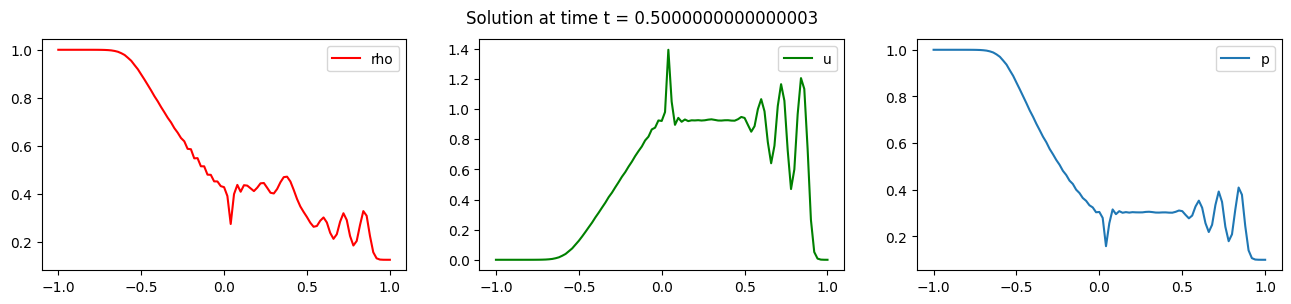

In [176]:
pv_res = np.array([consToPrim(s) for s in skp1])

fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
axs[2].plot(x_mesh, pv_res[:, 2], label='p')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle('Solution at time t = ' + str(t))

#### Визуализация решения (GIF)

In [177]:
frames = []
save_interval = 50
step = 0

# решение на слое k+1
skp1 = s0.copy()

# решение на слое k
sk = s0.copy()

# Настройка графика
fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].set_ylim(0, 1.2)
axs[1].set_ylim(-0.2, 0.8)
axs[2].set_ylim(0, 1.2)

t = 0
while t < 0.5:
    # заполняем данными с предыдущего шага
    sk = skp1.copy()

    tau = 0.001 # постоянный шаг
    
    for n in range(1, nx-1):
        skp1[n] = LaxWendroff(sk[n-1], sk[n], sk[n+1], tau, h)

    skp1[0] = primToCons(pvl)   # граничное условие для левой границы
    skp1[-1] = primToCons(pvr)  # граничное условие для правой границы
    
    t += tau
    step += 1

    pv_res = np.array([consToPrim(s) for s in skp1])

    for ax in axs:
        ax.clear()

    if step % save_interval == 0:
        axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
        axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
        axs[2].plot(x_mesh, pv_res[:, 2], label='p')
        axs[0].legend()
        axs[1].legend()
        axs[2].legend()
        fig.suptitle(f'Solution at time t = {t:.3f}')
        
        filename = f'frame_{step}.png'
        plt.savefig(filename)
        frames.append(imageio.imread(filename))
        os.remove(filename)

plt.close()

C:\Users\d.r.tikhonov\AppData\Local\Temp\ipykernel_426160\142004649.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))


In [178]:
output_dir = os.path.join("..", "output")
os.makedirs(output_dir, exist_ok=True)
file_path = os.path.join(output_dir, 'simple_Lax_Wendroff_const_t.gif')
imageio.mimsave(file_path, frames, fps=60)

#### Численное решение с переменным шагом

In [179]:
tau_list = []

# решение на слое k+1
skp1 = s0.copy()

# решение на слое k
sk = s0.copy()

t = 0
while t < 0.5:
    # заполняем данными с предыдущего шага
    sk = skp1.copy()

    tau = get_tau(h, sk) # переменный шаг
    tau_list.append(tau)

    for n in range(1, nx-1):
        skp1[n] = LaxWendroff(sk[n-1], sk[n], sk[n+1], tau, h)

    skp1[0] = primToCons(pvl)   # граничное условие для левой границы
    skp1[-1] = primToCons(pvr)  # граничное условие для правой границы
    
    t = t + tau

Text(0.5, 0.98, 'Solution at time t = 0.5036750544047094')

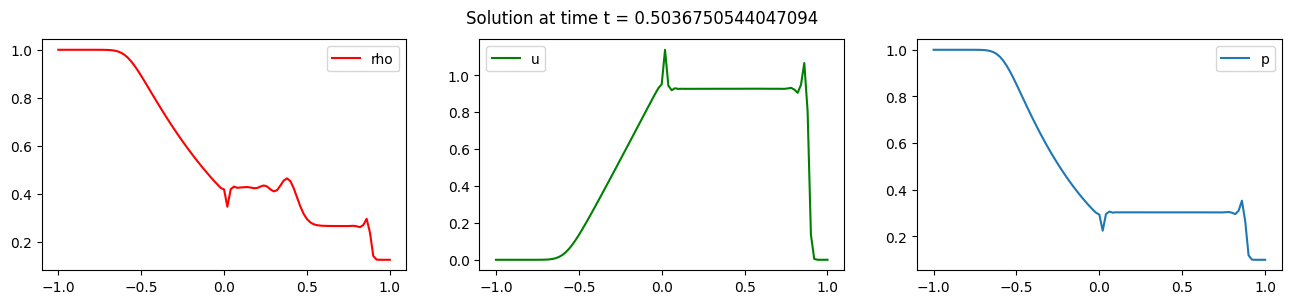

In [180]:
pv_res = np.array([consToPrim(s) for s in skp1])

fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
axs[2].plot(x_mesh, pv_res[:, 2], label='p')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle('Solution at time t = ' + str(t))

Из графиков видно, что волна разрежения распространяется влево, а ударная волна и контактный разрыв – вправо. Контактный разрыв наблюдается, когда есть *скачок* по плотности, но нет *скачка* по скорости и давлению; ударная волна, когда есть *скачок* по всем трём параметрам.

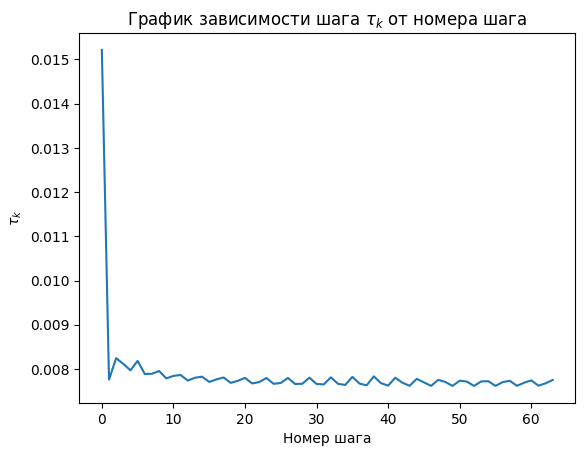

In [181]:
plt.plot(range(len(tau_list)), tau_list)
plt.xlabel('Номер шага')
plt.ylabel(r'$\tau_k$')
plt.title(r'График зависимости шага $\tau_k$ от номера шага')
plt.show()

#### Визуализация решения (GIF)

In [182]:
frames = []
save_interval = 10
step = 0

# решение на слое k+1
skp1 = s0.copy()

# решение на слое k
sk = s0.copy()

# Настройка графика
fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].set_ylim(0, 1.2)
axs[1].set_ylim(-0.2, 0.8)
axs[2].set_ylim(0, 1.2)

t = 0
while t < 0.5:
    # заполняем данными с предыдущего шага
    sk = skp1.copy()

    tau = get_tau(h, sk) # переменный шаг
    
    for n in range(1, nx-1):
        skp1[n] = LaxWendroff(sk[n-1], sk[n], sk[n+1], tau, h)

    skp1[0] = primToCons(pvl)   # граничное условие для левой границы
    skp1[-1] = primToCons(pvr)  # граничное условие для правой границы
    
    t += tau
    step += 1

    pv_res = np.array([consToPrim(s) for s in skp1])

    for ax in axs:
        ax.clear()

    if step % save_interval == 0:
        axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
        axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
        axs[2].plot(x_mesh, pv_res[:, 2], label='p')
        axs[0].legend()
        axs[1].legend()
        axs[2].legend()
        fig.suptitle(f'Solution at time t = {t:.3f}')
        
        filename = f'frame_{step}.png'
        plt.savefig(filename)
        frames.append(imageio.imread(filename))
        os.remove(filename)

plt.close()

C:\Users\d.r.tikhonov\AppData\Local\Temp\ipykernel_426160\2742964758.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))


In [183]:
output_dir = os.path.join("..", "output")
os.makedirs(output_dir, exist_ok=True)
file_path = os.path.join(output_dir, 'simple_Lax_Wendroff_var_t.gif')
imageio.mimsave(file_path, frames, fps=60)

### Схема Лакса-Вендроффа с искусственной вязкостью

Модифицированную систему уравнений можно записать в виде
$$
\frac{\partial{\bm{s}}}{\partial{t}} + \frac{\partial{\bm{f}(\bm{s})}}{\partial{x}} = \frac{\partial}{\partial x} \left( \mu \bm{B}(\bm{s}) \frac{\partial \bm{s}}{\partial x} \right),
$$
где $\bm{B}(\bm{s})$ – квадратная матрица, $\mu$ – коэффициент искусственной вязкости. Матрица $\bm{B}(\bm{s})$ должна быть подобрана таким образом, чтобы решение $\bm{s}(x,t)$ обладало достаточной гладкостью и при $\mu \rightarrow 0$ приближалось к решению исходной системы. В простейшем случае можно положить $\mu = \mu_a(t) h^2$, $\bm{B}(\bm{s}) = \bm{I}$.
Приходим к схеме Лакса-Вендроффа с искусственной вязкостью:
$$
\bm{s}_n^{k+1} = \bm{s}_n^{k} - \frac{\tau}{h} \left( \bm{f}_{n+1/2}^{k+1/2} - \bm{f}_{n-1/2}^{k+1/2} \right) + \mu_a^k(t) \tau \left( \bm{s}_{n+1}^{k} - 2\bm{s}_{n}^{k} + \bm{s}_{n-1}^{k} \right),
$$
где
$$
\bm{f}_{n}^{k} = \bm{f}(\bm{s}_{n}^{k}), \quad \bm{s}_{n+1/2}^{k+1/2} = \frac{1}{2} \left( \bm{s}_{n+1}^{k} - \bm{s}_n^{k} \right) - \frac{\tau}{2h} \left( \bm{f}_{n+1}^{k} - \bm{f}_{n}^{k} \right), \quad n = 1, \dots, N-1.
$$
Обозначим постоянный малый параметр $\nu = \mu_a^k(t) \tau$; величина $\nu$ подбирается экспериментально.

In [184]:
# Подбираем константу экспериментально
nu = 0.06

# Вычисление шага по времени
def get_tau_viscosity(h, sk):
    pv = np.array([consToPrim(s) for s in sk])    
    rho = pv[:,0]
    u = pv[:,1]
    p = pv[:,2]
    
    tau_k = h / np.max(np.abs(u) + np.sqrt(gamma * p / rho))
    return tau_k * np.sqrt(1 - 2 * nu)

def LaxWendroff_with_viscosity(snm1, sn, snp1, tau, h):
    s_left = 0.5 * (sn + snm1) - tau / (2 * h) * (flux(sn) - flux(snm1))
    s_right = 0.5 * (snp1 + sn) - tau / (2 * h) * (flux(snp1) - flux(sn))
      
    f_left = flux(s_left)
    f_right = flux(s_right)
    
    return sn - (tau / h) * (f_right - f_left) + nu * (snp1 - 2*sn + snm1)

In [185]:
tau_list = []

# решение на слое k+1
skp1 = s0.copy()

# решение на слое k
sk = s0.copy()

t = 0
while t < 0.5:
    # заполняем данными с предыдущего шага
    sk = skp1.copy()

    tau = get_tau_viscosity(h, sk) # переменный шаг
    tau_list.append(tau)

    for n in range(1, nx-1):
        skp1[n] = LaxWendroff_with_viscosity(sk[n-1], sk[n], sk[n+1], tau, h)

    skp1[0] = primToCons(pvl)   # граничное условие для левой границы
    skp1[-1] = primToCons(pvr)  # граничное условие для правой границы
    
    t = t + tau

Text(0.5, 0.98, 'Solution at time t = 0.5012890365234646')

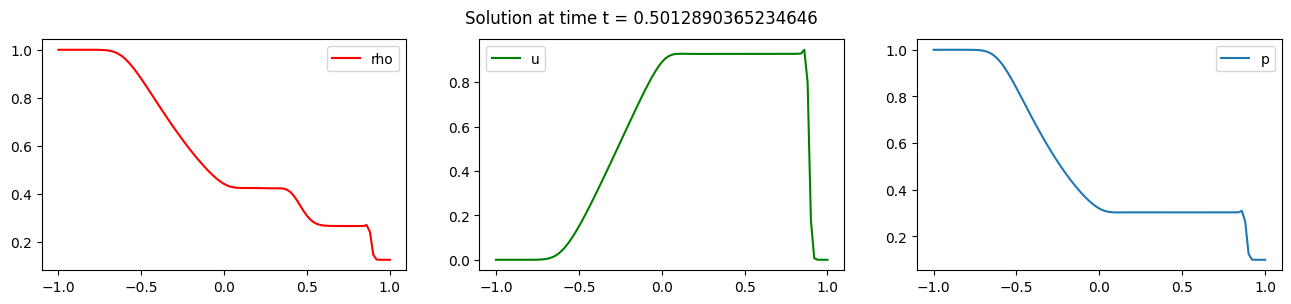

In [186]:
pv_res = np.array([consToPrim(s) for s in skp1])

fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
axs[2].plot(x_mesh, pv_res[:, 2], label='p')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle('Solution at time t = ' + str(t))

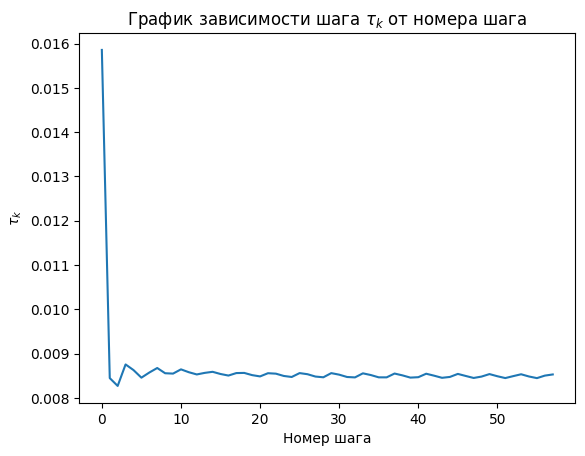

In [187]:
plt.plot(range(len(tau_list)), tau_list)
plt.xlabel('Номер шага')
plt.ylabel(r'$\tau_k$')
plt.title(r'График зависимости шага $\tau_k$ от номера шага')
plt.show()

#### Визуализация решения (GIF)

In [188]:
frames = []
step = 0

# решение на слое k+1
skp1 = s0.copy()

# решение на слое k
sk = s0.copy()

# Настройка графика
fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].set_ylim(0, 1.2)
axs[1].set_ylim(-0.2, 0.8)
axs[2].set_ylim(0, 1.2)

t = 0
while t < 0.5:
    # заполняем данными с предыдущего шага
    sk = skp1.copy()

    tau = get_tau_viscosity(h, sk) # переменный шаг
    
    for n in range(1, nx-1):
        skp1[n] = LaxWendroff_with_viscosity(sk[n-1], sk[n], sk[n+1], tau, h)

    skp1[0] = primToCons(pvl)   # граничное условие для левой границы
    skp1[-1] = primToCons(pvr)  # граничное условие для правой границы
    
    t += tau
    step += 1

    pv_res = np.array([consToPrim(s) for s in skp1])

    for ax in axs:
        ax.clear()

    axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
    axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
    axs[2].plot(x_mesh, pv_res[:, 2], label='p')
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    fig.suptitle(f'Solution at time t = {t:.3f}')
    
    filename = f'frame_{step}.png'
    plt.savefig(filename)
    frames.append(imageio.imread(filename))
    os.remove(filename)

plt.close()

C:\Users\d.r.tikhonov\AppData\Local\Temp\ipykernel_426160\4067811736.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))


In [189]:
output_dir = os.path.join("..", "output")
os.makedirs(output_dir, exist_ok=True)
file_path = os.path.join(output_dir, 'Lax_Wendroff_viscosity_var_t.gif')
imageio.mimsave(file_path, frames, fps=60)